# Improving Mock Data Errors with Emperical Results

The data in this notebook is generated in the same way as in `Bootstrap-Own-Data.ipynb`. However, instead of bootstrapping to get error estimates, each sample will be given it's own error estimate based on the mass-to-distance ratio, $\frac{m_1}{d_L}$. The exact formula comes from a logramthic least-squares fit from the LIGO O3a and b datasets, which can be found [here](https://github.com/ctmurphey/Combined-O3ab). These functions are already stored in `MCMC_functions.py`.

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

35.04577533068121 2.3625069407641894 117.79707929869271
(10000,)


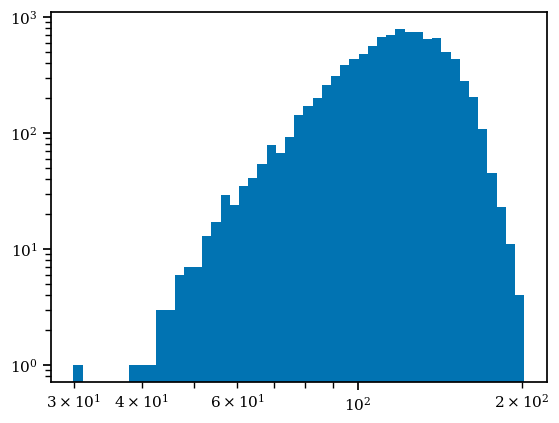

In [3]:
ms = generate_masses(f=1)
d_Ls = generate_dLs()
z_s = dLs_to_zs(d_Ls)

m_det = ms*(1+z_s)
print(np.mean(ms), np.mean(z_s), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

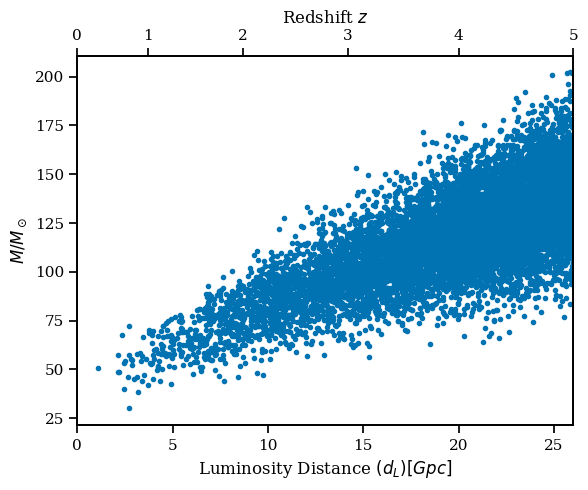

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(d_Ls/1000, m_det, marker='.')
ax1.set_xlabel(r"Luminosity Distance $(d_L) [Gpc]$")
ax1.set_ylabel(r"$M/M_\odot$")

tick_labels = np.linspace(0, 5, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax2.set_xlim(0, 5)
ax1.set_xlim(0, max(d_Ls/1000))
ax2.set_xticks(new_tick_locations.value)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel(r"Redshift $z$")
plt.show()